Using data from [Taarifa](https://http://taarifa.org/) and the [Tanzanian Ministry of Water](https://www.maji.go.tz/), can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.
One can also view the dataset in [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold,RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from pandas_profiling import ProfileReport 

In [2]:
#Importing the datasets
train_df = pd.read_csv('Training set values.csv',index_col='id')
test_df = pd.read_csv('Test Set values.csv',index_col='id')
target_df = pd.read_csv('Training set Labels.csv',index_col='id')

In [3]:
target_df.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [4]:
print("Train Data shape",train_df.shape)
print("Test Data shape",test_df.shape)

Train Data shape (59400, 39)
Test Data shape (14850, 39)


In [5]:
def feature_info(features):
  print('Unique values in the feature:')
  print(features.nunique())
  print('\nNo of Null values:')
  print(features.isna().sum())
feature_info(train_df)

Unique values in the feature:
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_g

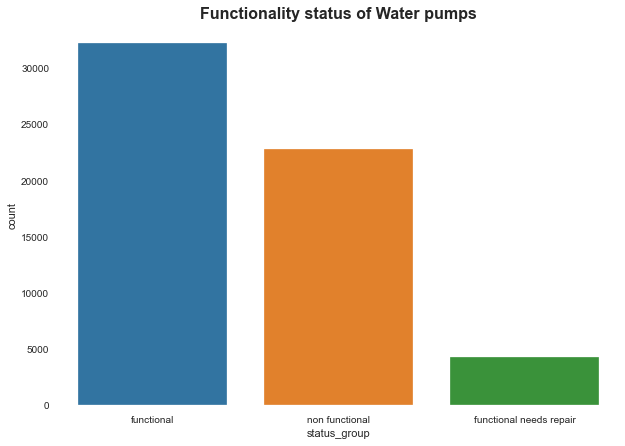

In [6]:
plt.figure(figsize=(10,7))
plt.title("Functionality status of Water pumps",fontsize=16, fontweight='bold')
sns.countplot(x=target_df['status_group'], data=target_df)

In [7]:
#From the date_recorded column we are extracting the year month and day and creating respective columns in the dataset
def convert_datetime(df, col):
  df[col] = pd.to_datetime(df[col])
  df['year'] = df[col].dt.year
  df['month'] = df[col].dt.month 
  df['day'] = df[col].dt.day 
  
  return None

In [8]:
convert_datetime(train_df,'date_recorded')
convert_datetime(test_df,'date_recorded')

In [9]:
train_copy = train_df.copy()
test_copy = test_df.copy()

**Let us clean the numerical columns to fill the bogus values with the appropriate ones**

In [16]:
class NumericalCleaner(BaseEstimator,TransformerMixin):
    def __init(self):
        self.num_cols =[]
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        imputer = SimpleImputer(strategy = "median")
        self.num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private','population','construction_year']
        num_list = X[self.num_cols]
        
        for num in num_list:
            num_list[num] = num_list[num].replace({0:np.nan, -2.000000e-08:np.nan})
        
        imputer.fit(num_list)
        Xnum = imputer.transform(num_list)
        DF_num = pd.DataFrame(Xnum,columns=num_list.columns,index = list(X.index.values))
        
        for col_names,col_content in DF_num.iteritems():
            X[col_names] = col_content
        return X

In [21]:
numcleaner = NumericalCleaner()
train_copy = numcleaner.fit_transform(train_copy)
test_copy = numcleaner.transform(test_copy)

C:\Users\avina\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\avina\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [22]:
train_copy.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [23]:
train_copy.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'year',
       'month', 'day'],
      dtype='object')

**Lets create a custom transformer that replaces the unknown values to Nan and replaces them with their mode**

In [24]:
class CategoricalCleaner(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.cols = ['funder','installer','wpt_name','basin', 'subvillage', 
                         'region', 'lga', 'ward','public_meeting', 'recorded_by', 
                         'scheme_management', 'scheme_name', 'permit','extraction_type',
                         'extraction_type_group', 'extraction_type_class', 'management', 
                         'management_group', 'payment', 'payment_type', 'water_quality', 
                         'quality_group', 'quantity', 'quantity_group', 'source',
                         'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        imputer = SimpleImputer(strategy='most_frequent')
        cat_cols = X[self.cols]  # Extracting the data frame having the columns of cols
        
        for cc in cat_cols:
            cat_cols[cc] = cat_cols[cc].replace({'0':np.nan, 'not known':np.nan, 'Not Known':np.nan, 'None':np.nan, 'unknown':np.nan, 'none':np.nan, '-':np.nan, '##':np.nan, 'not kno':np.nan, 'Unknown Installer':np.nan})  
        
        imputer.fit(cat_cols)
        Xcat = imputer.transform(cat_cols)  # all the Nan are filled with the most frequent item of that column
        DF_cat = pd.DataFrame(Xcat,columns=cat_cols.columns, index = list(X.index.values))
        
        for col_name,col_content in DF_cat.iteritems():  # Now returning a dataframe that which has the modified rows for a particular column
            X[col_name] = col_content
        
        return X
        

In [25]:
catcleaner = CategoricalCleaner()
train_copy = catcleaner.fit_transform(train_copy)
test_copy = catcleaner.transform(test_copy)

C:\Users\avina\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\avina\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
train_copy.dtypes

amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                      float64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                     float64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                      float64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year               float64
extraction_type                  object
extraction_type_group            object


**Drop Features**

In [27]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.drop_cols = ['longitude','latitude',
              'extraction_type_group','extraction_type_class',
              'region_code','waterpoint_type_group','source_type',
              'payment_type','quality_group','quantity_group','date_recorded']
    
    def fit(self,X,y=None):    #The fit function always returns self doesnt matter what 
        return self
    def transform(self,X):
        return X.drop(self.drop_cols,axis=1)
        

In [28]:
feature_dropper = DropFeatures()
train_copy = feature_dropper.transform(train_copy)
test_copy = feature_dropper.transform(test_copy)

In [29]:
print("Training shape before dummifying",train_copy.shape)
print("Test set shape before dummifying",test_copy.shape)

Training shape before dummifying (59400, 31)
Test set shape before dummifying (14850, 31)


In [30]:
train_copy.head()

,amount_tsh,funder,gps_height,installer,wpt_name,num_private,basin,subvillage,region,district_code,...,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,year,month,day
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390.0,Roman,Shuleni,15.0,Lake Nyasa,Mnyusi B,Iringa,5,...,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe,2011,3,14
8776,250.0,Grumeti,1399.0,GRUMETI,Zahanati,15.0,Lake Victoria,Nyamara,Mara,2,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,2013,3,6
34310,25.0,Lottery Club,686.0,World vision,Kwa Mahundi,15.0,Pangani,Majengo,Manyara,4,...,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,2013,2,25
67743,250.0,Unicef,263.0,UNICEF,Zahanati Ya Nanyumbu,15.0,Ruvuma / Southern Coast,Mahakamani,Mtwara,63,...,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,2013,1,28
19728,250.0,Action In A,1167.0,Artisan,Shuleni,15.0,Lake Victoria,Kyanyamisa,Kagera,1,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,2011,7,13


In [31]:
y_train = target_df['status_group']

In [32]:
class ReduceCardinality(BaseEstimator, TransformerMixin):
    def __init__(self, date_recorded = False):
        self.col_dict  = {}
    
    def fit(self, X, y=None):
        for col in X.columns:
            if (X[col].dtype == np.object) and len(X[col].unique()) > 500:
                val_count = X[col].value_counts()
                val_count = val_count[val_count >20]
                self.col_dict[col] = val_count
         
        return self
    
    def transform(self, X):
        for col in X.columns:
            if col in self.col_dict:
                X[col] = X[col].map(lambda x: x if x in(self.col_dict[col]) else 'other')
        
        return X

In [33]:
cardReducer = ReduceCardinality()
df_train = cardReducer.fit_transform(train_copy)
df_test = cardReducer.transform(test_copy)

In [34]:
# Deleting the high cardinality columns and the columns which has only one level
#high_card_cols = ['funder','installer','subvillage','wpt_name','scheme_name','ward','recorded_by']
#X_train_updated = train_copy.drop(high_card_cols,axis=1)
#X_test_updated = test_copy.drop(high_card_cols,axis=1)

In [35]:
print("The shape of training set after dropping high cardinality columns",df_train.shape)
print("The shape of test set after dropping high cardinality columns",df_test.shape)

The shape of training set after dropping high cardinality columns (59400, 31)
The shape of test set after dropping high cardinality columns (14850, 31)


In [36]:
#Now we can proceed with Encoding the features using the get_dummies() function
categorial_cols = ['basin', 'region','lga', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'management', 'management_group', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type',
       'funder','installer','subvillage','wpt_name','scheme_name','ward','recorded_by']
def dummies(data):
  for cc in categorial_cols:
    dummies = pd.get_dummies(data[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data.drop(cc, axis=1, inplace=True)
    data = data.join(dummies)
  return data

In [37]:
X_train = dummies(df_train)
X_test = dummies(df_test)

There might be  mismatch between the number of columns so I will go ahead and remove the columns which arent there in both.

In [38]:
x = list(X_train.columns)
y = list(X_test.columns)

In [39]:
def mismatch(x,y):
  tr=[]
  te=[]
  for i in range(0,len(x)) :
    if x[i] not in y:
      tr.append(x[i])
  for j in range(0,len(y)) :
    if y[j] not in x:
      te.append(y[j])
  return tr,te

list_tr,list_te = mismatch(x,y)

In [40]:
X_train =  X_train.drop(list_tr,axis=1)
X_test = X_test.drop(list_te,axis=1)

c = list(X_train.columns.values)
d = list(X_test.columns.values)

c == d

True

In [41]:
print("The training set shape",X_train.shape)
print("The Test set shape",X_test.shape)

The training set shape (59400, 2443)
The Test set shape (14850, 2443)


In [42]:
# Normalization of the numerical features
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

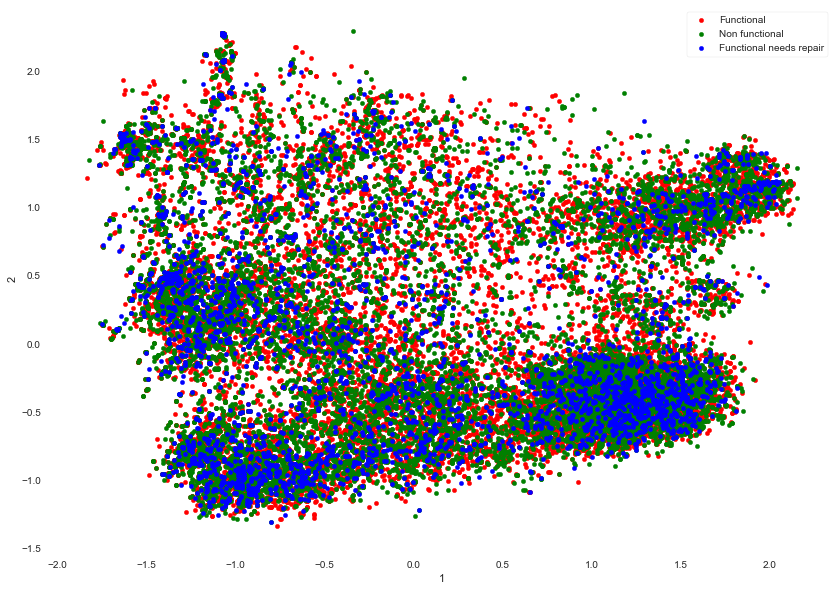

In [43]:
pca = PCA(n_components=2)
X_train_viz = pca.fit_transform(X_train)

df_PCA = pd.DataFrame(X_train_viz, columns=[1,2])
df_PCA['label'] = y_train

ax = df_PCA[df_PCA.label=='functional'].plot(kind='scatter', x=1, y=2, color='r', 
                                             label='Functional', figsize=(14,10))
df_PCA[df_PCA.label=='non functional'].plot(kind='scatter', x=1, y=2, color='g', 
                                            label='Non functional', ax=ax)
df_PCA[df_PCA.label=='functional needs repair'].plot(kind='scatter', x=1, y=2, color='b', 
                                               label='Functional needs repair', ax=ax);

As we can see that with 2 components we arent able to distinguish the features at all.

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_reduced_train = pca.fit_transform(X_train)
X_reduced_test=pca.transform(X_test)

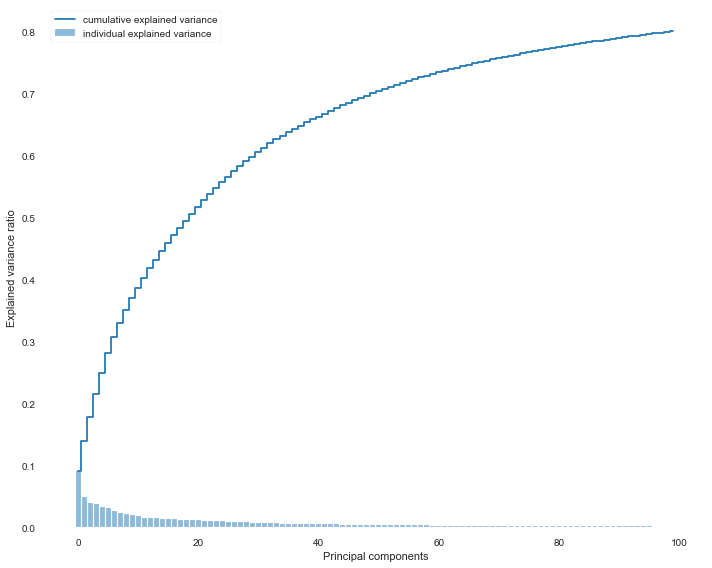

In [46]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
var_exp = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
plt.bar(range(100), var_exp, alpha=0.5, align='center',
       label='individual explained variance')
plt.step(range(100), cumsum, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [47]:
X_reduced_train.shape , X_reduced_test.shape, len(y_train)

((59400, 100), (14850, 100), 59400)

In [48]:
kfold = StratifiedKFold(n_splits=10)

The CV Accuracy: %.3f +/- %.3f


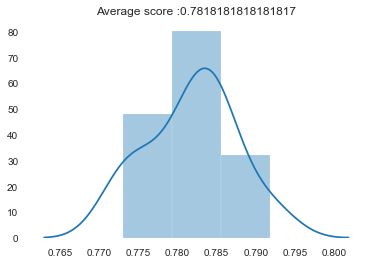

In [50]:
cv_scores = cross_val_score(RandomForestClassifier(),X_reduced_train,y_train,cv=kfold)
sns.distplot(cv_scores)
plt.title('Average score :{}'.format(np.mean(cv_scores)))
print("The CV Accuracy: %.3f +/- %.3f".format(np.mean(cv_scores),np.std(cv_scores)))